# Exploring the Jaynes-Cummings Hamiltonian with Qiskit Pulse

### Physics Background

The Jaynes-Cummings model describes a two-level system (qubit) interacting with a single-mode of an electromagnetic cavity (resonator). When a two-level system is placed in a cavity, it couples to the cavity with strength $g$, spontaneously emits its excitation with rate $\gamma$, while the cavity decays with rate $\kappa$. In this tutorial we measure the parameters of a system consting of a superconducting qubit coupled to a superconducting resonator using Qiskit Pulse.

<img src="images/CQED.png" width="250"/>

This qubit-cavity interaction can be described using the Jaynes-Cummings (JC) Hamiltonian: 

$H_{JC}/\hbar=\omega_r(a^\dagger a) - \frac{1}{2} \omega_q \sigma_z + g (\sigma_+ a + \sigma_- a^\dagger)$

Let's break down this Hamiltonian in different parts: The first part of the Hamiltonian $H_r/\hbar=\omega_r(a^\dagger a)$ describes the resonator. The resonator can be treated as a quantum harmonic oscillator, where $\omega_r$ is the resonator frequency, and $a$ and $a^\dagger$ are the raising a lowering operators of the resonator photons. Note that for simplicity we have omitted the zero point enegery of the harmonic oscillator. The next term in the JC Hamiltoninan $H_q/\hbar=-\frac{1}{2} \omega_q \sigma_z$ describes the qubit. Here, $\omega_q$ is the qubit frequency, and $\sigma_z$ is the Pauli-Z operator. The final term of the Hamiltonian $H_{rq}/\hbar=g (\sigma_+ a + \sigma_- a^\dagger)$ describes the interaction between the resonator and the qubit: $g$ is the coupling strength between the qubit and the resonator, and the operators $\sigma_+$ and $\sigma_-$ represent exciting and de-exciting the qubit. Based on this interaction term we can see that the process of exciting a qubit leads to a photon loss in the resonator and vice-versa. 

In the limit that detuning between the qubit and the resonator $\Delta=\omega_q-\omega_r$ is less than the coupling strength between the two, $|\Delta|\ll g$, the resonator-qubit system becomes hybridized, leading to coherent excitation swaps which can be useful for certain two-qubit operations. However, for optimal readout, we want to operate the system in the dispersive limit, where the qubit-resonator detuning is much larger than the coupling rate and the resonator decay rate: $|\Delta| \gg g,\kappa$. In this limit the interaction between the qubit and resonator influences each of their frequencies, a feature that can be used for measuring the state of the qubit. We can apply the dispersive approximation in the limit of few photons in the resonator, and approximate the JC Hamiltonian using second-order perturbation theory as: 

$H_{JC(disp)}/\hbar=(\omega_r+ \chi \sigma_z) a^\dagger a + \frac{1}{2} \tilde{\omega}_q \sigma_z$

where $\chi=-g^2/\Delta$ is the dispersive shift (the negative sign is ue to the fact that the transmon has a negative anharmonicity), and $\tilde{\omega}_q= \omega_q+g^2/\Delta$ is the modified qubit frequency, experiencing a Lamb shift.

The circuit quantum electrodynamics derivations are disscussed in another <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a>. 

### 0. Getting started

We'll first get our basic dependencies and helper functions set up and ready to go.

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import SchedStyle
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

C:\Users\karam\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


We then extract the default backend configuration and settings for the selected chip

In [1]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []  # Will allow us to send a larger waveform for our experiments
style = SchedStyle(figsize=(3, 2), title_font_size=10, axis_font_size=8) # style for displaying the pulse sequence

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Next we define some helper functions that we will use for fitting and interpreting our data

In [2]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# process the reflective measurement results
# in a reflective measurement the data is encoded in the phase of the output signal
def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),3,2),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return -a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmin(values)],(freqs[-1]-freqs[0])/2,min(values),0]
    bounds=([freqs[0],0,-np.inf,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# exponential function
def exponential(t,tau,a,offset):
    return a*np.exp(-t/tau)+offset

# fit an exponential function
def fit_exponential(ts,values):
    p0=[np.average(ts),1,0]
    return curve_fit(exponential, ts, values,p0=p0)

### 1. Measuring $\kappa$

Photons decay out of imperfect electromagnetic cavities. The decay rate $\kappa$ for the resonator cavity can be measured by calculating the linewidth of the resonance peak in a resonator spectroscopy scan. Larger values of $\kappa$ imply that the resonator cavity is more lossy. The resonator loss can be quantified using the quality factor $Q=\omega_r/\kappa$; higher $Q$ indicates a lower rate of energy loss from the cavity.

In [3]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib
import numpy as np

dt=backend_config.dt   # hardware resolution

qubit=0   # qubit used in our experiment

readout_time = 4e-6
readout_sigma = 10e-9 

# low power drive for the resonator for dispersive readout
# We use a square pulse with a Guassian rise and fall time
readout_drive_low_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = .3,
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'low power readout tone')

meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

# readout output signal acquisition setup
acquisition_time = readout_time   # We want to acquire the readout signal for the full duration of the readout

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  This is separate from the ipykernel package so we can avoid doing imports until


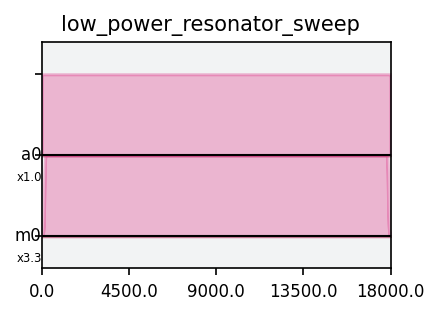

In [4]:
# build the pulse sequence for low power resonator spectroscopy
with pulse.build(name='low_power_resonator_sweep') as pulse_low_power:
    #drive the resonator with low power
    pulse.play(readout_drive_low_power, meas_chan) 
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_low_power.draw(style=style)

In [5]:
center_freq = backend_defaults.meas_freq_est[qubit]  # an estimate for the resonator frequency
freq_span = 0.3e6 # resonator scan span. The span should be larger than the resonator linewidth kappa

frequencies_range = np.linspace(center_freq-freq_span/2,center_freq+freq_span/2,41)
# list of resonator frequencies for the experiment
schedule_frequencies = [{meas_chan: freq} for freq in frequencies_range] 

Here we send our pulse sequence to the hardware

In [6]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots_per_frequency = 2*1024 
frequency_sweep_low_power = assemble(pulse_low_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_low_power = backend.run(frequency_sweep_low_power)
job_monitor(job_low_power)

low_power_sweep_results = job_low_power.result(timeout=120)

/opt/conda/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


Job Status: job has successfully run


And then we access the measurement data. The resonator in the backend we use for this tutorial is measured reflectively, so the spectroscopy data is encoded in the phase of the output signal. We fit a Lorentzian function to the data to extract the resonator frequency and linewidth.

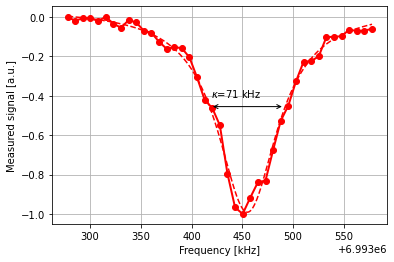

In [7]:
import matplotlib.pyplot as plt

low_power_sweep_values = []
for i in range(len(low_power_sweep_results.results)):
    res_low_power = low_power_sweep_results.get_memory(i)
    low_power_sweep_values.append(res_low_power[qubit])

low_power_sweep_values = process_reflective_measurement(frequencies_range,low_power_sweep_values)

plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)

popt_low_power,_=fit_lorentzian(frequencies_range,low_power_sweep_values)
f0, kappa, a, offset = popt_low_power

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')
plt.annotate("", xy=((f0-kappa/2)/1e3, offset-1/2), xytext=((f0+kappa/2)/1e3, offset-1/2), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\kappa$={:d} kHz".format(int(kappa/1e3)), xy=((f0-kappa/2)/1e3, offset-.45), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

### 2. Measuring $\chi$ and $g$

Next, we measure the qubit-resonator coupling. One method for measuring the dispersive shift ($\chi$) and subsequently the qubit-resonator coupling ($g=\sqrt{\chi.\Delta}$) is to compare the resonator frequency in the dispersive limit with the frequency in the non-interactive regime, where the resonator does not get shifted by $\chi$. In the non-interactive limit the resonator photon number $n=a^\dagger a$ is larger than $n_c=\frac{\Delta^2}{4g^2}$. In experiment we can populate the resonator with more photons by driving it with more power.

In [8]:
readout_drive_high_power=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(readout_time//dt),
                             amp = 1, # High drive amplitude
                             sigma = get_closest_multiple_of_16(readout_sigma//dt),
                             width = get_closest_multiple_of_16((readout_time-8*readout_sigma)//dt),
                             name = 'high power readout tone')

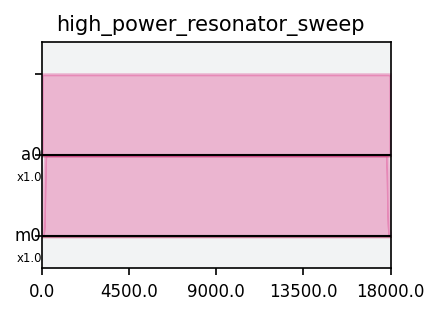

In [9]:
# build the pulse sequence for high power resonator spectroscopy
with pulse.build(name='high_power_resonator_sweep') as pulse_high_power:
    #drive the resonator with high power
    pulse.play(readout_drive_high_power, meas_chan)
    #acquire the readout signal
    pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                    qubit_or_channel = acq_chan,
                    register = pulse.MemorySlot(0))
    
pulse_high_power.draw(style=style)

Here we send our pulse sequence to the hardware

In [10]:
frequency_sweep_high_power = assemble(pulse_high_power,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job_high_power = backend.run(frequency_sweep_high_power)
job_monitor(job_high_power)

high_power_sweep_results = job_high_power.result(timeout=120)

/opt/conda/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


Job Status: job has successfully run


And then we access the measurement data for the high power resonator spectroscopy scan

In [11]:
high_power_sweep_values = []
for i in range(len(high_power_sweep_results.results)):
    res_high_power = high_power_sweep_results.get_memory(i)
    high_power_sweep_values.append(res_high_power[qubit])

high_power_sweep_values = process_reflective_measurement(frequencies_range,high_power_sweep_values)

popt_high_power,_=fit_lorentzian(frequencies_range,high_power_sweep_values)

Finally we plot the high power resonator spectroscopy next to the low power scan from the previous section and use the shift in resonator frequency to calculate $\chi$

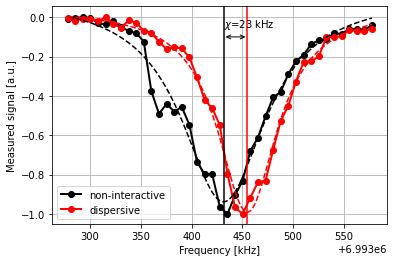

chi=23.5 kHz
g=6.9 MHz


In [12]:
plt.plot(frequencies_range/1e3, high_power_sweep_values, '-o', color='black', lw=2, label='non-interactive')
plt.plot(frequencies_range/1e3, low_power_sweep_values,'-o', color='red', lw=2, label='dispersive')

fs=np.linspace(frequencies_range[0],frequencies_range[-1],1000)
plt.plot(fs/1e3, lorentzian(fs,*popt_high_power), color='black', ls='--')
plt.plot(fs/1e3, lorentzian(fs,*popt_low_power), color='red', ls='--')

plt.axvline(x=popt_low_power[0]/1e3, color='red')
plt.axvline(x=popt_high_power[0]/1e3, color='black')

chi=popt_low_power[0]-popt_high_power[0]
plt.annotate("", xy=(popt_low_power[0]/1e3, -.1), xytext=(popt_high_power[0]/1e3, -.1), arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate("$\chi$={:d} kHz".format(int(chi/1e3)), xy=(popt_high_power[0]/1e3, -.05), color='black')

plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.legend()
plt.show()

print(r'chi={:.1f} kHz'.format((popt_low_power[0]-popt_high_power[0])/1e3))
Delta=abs(backend_defaults.meas_freq_est[qubit] - backend_defaults.qubit_freq_est[qubit])
print(r'g={:.1f} MHz'.format(np.sqrt(chi*Delta)/1e6))

### 3. Measuring $\gamma$

A qubit coupled to a resonator will spontaneous emit photons into the cavity, and therefore relaxing from an excited state to the ground state. The spontaneous emission of photons gets enhanced by the qubit environment, a phenomenon known as the Purcell effect. We can measure the qubit decay rate $\gamma$ by exciting the qubit with a microwave drive, and measuring the decay rate $T_1=1/\gamma$ of the qubit excitation. This experiment is a common method method for measuring qubit coherence properties as discussed in this <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a>. For this experiment our microwave drive doesn't have to be $\pi$-pulse 

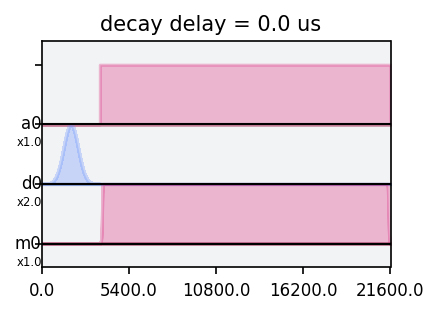

In [20]:
drive_sigma = 100e-9
drive_duration = 8*drive_sigma

# qubit micrwave drive
# We use a Gaussian pulse to excite our qubit
qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .5,
                             sigma = get_closest_multiple_of_16(drive_sigma//dt),
                             name = 'qubit tone')

drive_chan = pulse.DriveChannel(qubit) # qubit drive channel

# We drive our qubit, wait for some time (time delay), and then measure the qubit
# Using these measurements we can create a plot of qubit population vs. time delay
delay_times=np.linspace(0,600e-6,61) #measurement time delays
qubit_decay_pulses = []
for delay in delay_times:
    
    with pulse.build(name=f"decay delay = {delay * 1e6} us") as temp_decay_pulse:
        #drive the qubit
        pulse.play(qubit_drive, drive_chan)
        #meanwhile do nothing with the resonator
        pulse.delay(get_closest_multiple_of_16(drive_duration//dt), meas_chan)
        #wait for the duration of the time delay before measuring the qubit
        pulse.delay(int(delay//dt), meas_chan)
        
        #sequence for measuring the qubit
        with pulse.build() as temp_sched:
            #drive the resonator with low power
            pulse.play(readout_drive_low_power, meas_chan)
            #acquire the readout signal
            pulse.acquire(duration = get_closest_multiple_of_16(acquisition_time//dt),
                            qubit_or_channel = acq_chan,
                            register = pulse.MemorySlot(0))
        
        #call the measuring sequence
        pulse.call(temp_sched)
        
    qubit_decay_pulses.append(temp_decay_pulse)

qubit_decay_pulses[0].draw(style=style)

Here we send our pulse sequence to the hardware

In [23]:
# setting the readout frequency to the resontor frequecy in the dispersive limit measured earlier
# setting the qubit freqency to the default value
los = [{meas_chan: f0, drive_chan: backend_defaults.qubit_freq_est[qubit]}] # pulse frequencies for each channel

num_shots = 4*1024  # increasing this number will make your output more accurate,
                    # but it will slow down the experiment

qubit_decay_experiment = assemble(qubit_decay_pulses,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los= los * len(qubit_decay_pulses))

job_qubit_decay = backend.run(qubit_decay_experiment)
job_monitor(job_qubit_decay)

/opt/conda/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


Job Status: job has successfully run


And then we access the measurement data. We fit an exponential to the data to extract the decay time constant.

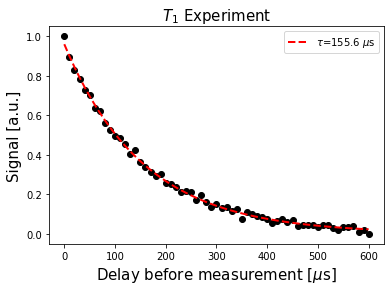

gamma=  6.43 kHz


In [25]:
qubit_decay_results = job_qubit_decay.result(timeout=120)

qubit_decay_values = []
for i in range(len(delay_times)):
    qubit_decay_values.append(qubit_decay_results.get_memory(i)[qubit])
qubit_decay_values = np.abs(qubit_decay_values)
qubit_decay_values = (qubit_decay_values-min(qubit_decay_values))
qubit_decay_values/=max(qubit_decay_values)

decay_popt,_=fit_exponential(delay_times, qubit_decay_values)
tau=decay_popt[0]
g=1/tau

plt.scatter(delay_times*1e6, qubit_decay_values, color='black') 
plt.plot(delay_times*1e6,exponential(delay_times,*decay_popt),'--',lw=2,color='red',label=r'$\tau$={:.1f} $\mu$s'.format(tau*1e6))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

print(r'gamma=  {:.2f} kHz'.format(g/1e3))

In this chapter we introduce the Jaynes-Cummings model and we consider the relevant quantities for a system consisting of a qubit coupled to a cavity. We use Qiskit Pulse to extract the qubit-resonator coupling strength $g$, the qubit spontaneous emission rate $\gamma$, and the cavity decay rate $\kappa$. These parameters combined with the qubit frequency and the resonator frequency that we measured in a previous <a href="https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html">chapter</a> allow us to describe our qubit-resonator system.

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.7.0',
 'qiskit-ignis': '0.5.0',
 'qiskit-ibmq-provider': '0.11.0',
 'qiskit-aqua': '0.8.0',
 'qiskit': '0.23.0'}